In [ ]:
!wget -O "leaf-disease-segmentation-dataset.zip" "https://www.kaggle.com/api/v1/datasets/download/fakhrealam9537/leaf-disease-segmentation-dataset"
!unzip /content/leaf-disease-segmentation-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: aug_data/aug_data/images/00411_1.jpg  
  inflating: aug_data/aug_data/images/00411_2.jpg  
  inflating: aug_data/aug_data/images/00411_3.jpg  
  inflating: aug_data/aug_data/images/00411_4.jpg  
  inflating: aug_data/aug_data/images/00412_0.jpg  
  inflating: aug_data/aug_data/images/00412_1.jpg  
  inflating: aug_data/aug_data/images/00412_2.jpg  
  inflating: aug_data/aug_data/images/00412_3.jpg  
  inflating: aug_data/aug_data/images/00412_4.jpg  
  inflating: aug_data/aug_data/images/00413_0.jpg  
  inflating: aug_data/aug_data/images/00413_1.jpg  
  inflating: aug_data/aug_data/images/00413_2.jpg  
  inflating: aug_data/aug_data/images/00413_3.jpg  
  inflating: aug_data/aug_data/images/00413_4.jpg  
  inflating: aug_data/aug_data/images/00414_0.jpg  
  inflating: aug_data/aug_data/images/00414_1.jpg  
  inflating: aug_data/aug_data/images/00414_2.jpg  
  inflating: aug_data/aug_data/images/00414_3.jpg  
  inflating: 

In [ ]:
import os
import glob
import numpy as np
import cv2  # OpenCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
IMAGE_DIR = "/content/aug_data/aug_data/images"
MASK_DIR = "/content/aug_data/aug_data/masks"

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

def load_data(image_dir, mask_dir):
    # Find all .jpg, .jpeg, and .png files in the directories
    image_paths = sorted(
        glob.glob(os.path.join(image_dir, "*.jpg")) +
        glob.glob(os.path.join(image_dir, "*.jpeg")) +
        glob.glob(os.path.join(image_dir, "*.png"))
    )
    mask_paths = sorted(
        glob.glob(os.path.join(mask_dir, "*.jpg")) +
        glob.glob(os.path.join(mask_dir, "*.jpeg")) +
        glob.glob(os.path.join(mask_dir, "*.png"))
    )

    if len(image_paths) == 0:
        print(f"Error: No images found in {image_dir}. (Searched for .jpg, .jpeg, .png)")
        return None, None

    if len(image_paths) != len(mask_paths):
        print(f"Error: Mismatch! Found {len(image_paths)} images but {len(mask_paths)} masks.")
        return None, None

    X_data = []
    y_data = []

    print(f"Loading {len(image_paths)} images and masks...")

    for img_path, mask_path in zip(image_paths, mask_paths):
        try:
            # Load Image (X) - 3 Channels
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
            X_data.append(img)

            # Load Mask (y) - 1 Channel (Grayscale)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
            y_data.append(mask)
        except Exception as e:
            print(f"Warning: Skipping file pair {img_path} / {mask_path} due to error: {e}")
            continue

    # Convert lists to numpy arrays
    # Normalize images (0-255) to (0-1)
    X = np.array(X_data, dtype=np.float32) / 255.0

    # Normalize masks (0 or 255) to (0 or 1)
    y = np.array(y_data, dtype=np.float32) / 255.0
    # Add a final 'channels' dimension for Keras (256, 256) -> (256, 256, 1)
    y = np.expand_dims(y, axis=-1)

    print(f"Data loaded. X (images) shape: {X.shape}, y (masks) shape: {y.shape}")
    return X, y

In [ ]:

# Load the data
X, y = load_data(IMAGE_DIR, MASK_DIR)

if X is None or len(X) == 0:
    raise ValueError("Data loading failed. Please check paths and file integrity.")
else:
    # Split data (80% train, 20% validation)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split: {len(X_train)} train images, {len(X_val)} validation images")


Loading 2940 images and masks...
Data loaded. X (images) shape: (2940, 256, 256, 3), y (masks) shape: (2940, 256, 256, 1)
Data split: 2352 train images, 588 validation images


In [ ]:

def dice_coefficient(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

print("Dice Loss and Dice Coefficient defined.")


Dice Loss and Dice Coefficient defined.


In [ ]:

def build_unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # --- Encoder (Contracting Path) ---
    c1 = layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.25)(p1) # <-- FIX FOR OVERFITTING

    c2 = layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.25)(p2) # <-- FIX FOR OVERFITTING

    c3 = layers.Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.25)(p3) # <-- FIX FOR OVERFITTING

    # --- Bottleneck ---
    b = layers.Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    b = layers.Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(b)
    b = layers.Dropout(0.5)(b) # <-- FIX FOR OVERFITTING

    # --- Decoder (Expansive Path) ---
    u1 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(b)
    u1 = layers.concatenate([u1, c3]) # Skip connection
    c5 = layers.Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u1)
    c5 = layers.Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u2 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2]) # Skip connection
    c6 = layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u2)
    c6 = layers.Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u3 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c1]) # Skip connection
    c7 = layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u3)
    c7 = layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # --- Output Layer (Binary) ---
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3) # 3 channels for RGB
model = build_unet_model(input_shape)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=[dice_coefficient, 'accuracy'])

print("Model built and compiled.")
model.summary()

Model built and compiled.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    524,544 │ dropout_3[0][0] 

 Total params: 7,697,345 (29.36 MB)

 Trainable params: 7,697,345 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# This will reduce the learning rate if the model gets "stuck"
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

# We can run for more epochs, EarlyStopping will find the best one
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopper, reduce_lr]
)


Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 198s 901ms/step - accuracy: 0.5144 - dice_coefficient: 0.0784 - loss: 0.9216 - val_accuracy: 0.7640 - val_dice_coefficient: 0.1323 - val_loss: 0.8677 - learning_rate: 1.0000e-04
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 98s 665ms/step - accuracy: 0.7885 - dice_coefficient: 0.1377 - loss: 0.8623 - val_accuracy: 0.7943 - val_dice_coefficient: 0.1503 - val_loss: 0.8498 - learning_rate: 1.0000e-04
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 98s 664ms/step - accuracy: 0.8028 - dice_coefficient: 0.1503 - loss: 0.8497 - val_accuracy: 0.7818 - val_dice_coefficient: 0.1540 - val_loss: 0.8460 - learning_rate: 1.0000e-04
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 97s 663ms/step - accuracy: 0.8079 - dice_coefficient: 0.1585 - loss: 0.8415 - val_accuracy: 0.7718 - val_dice_coefficient: 0.1533 - val_loss: 0.8467 - learning_rate: 1.0000e-04
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 97s 663ms/step - accuracy: 0.8156 - dice_coefficient: 0.1635 - loss: 0.8365 - val_accuracy:

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Saved prediction visualization to 'predictions_visualization.png'


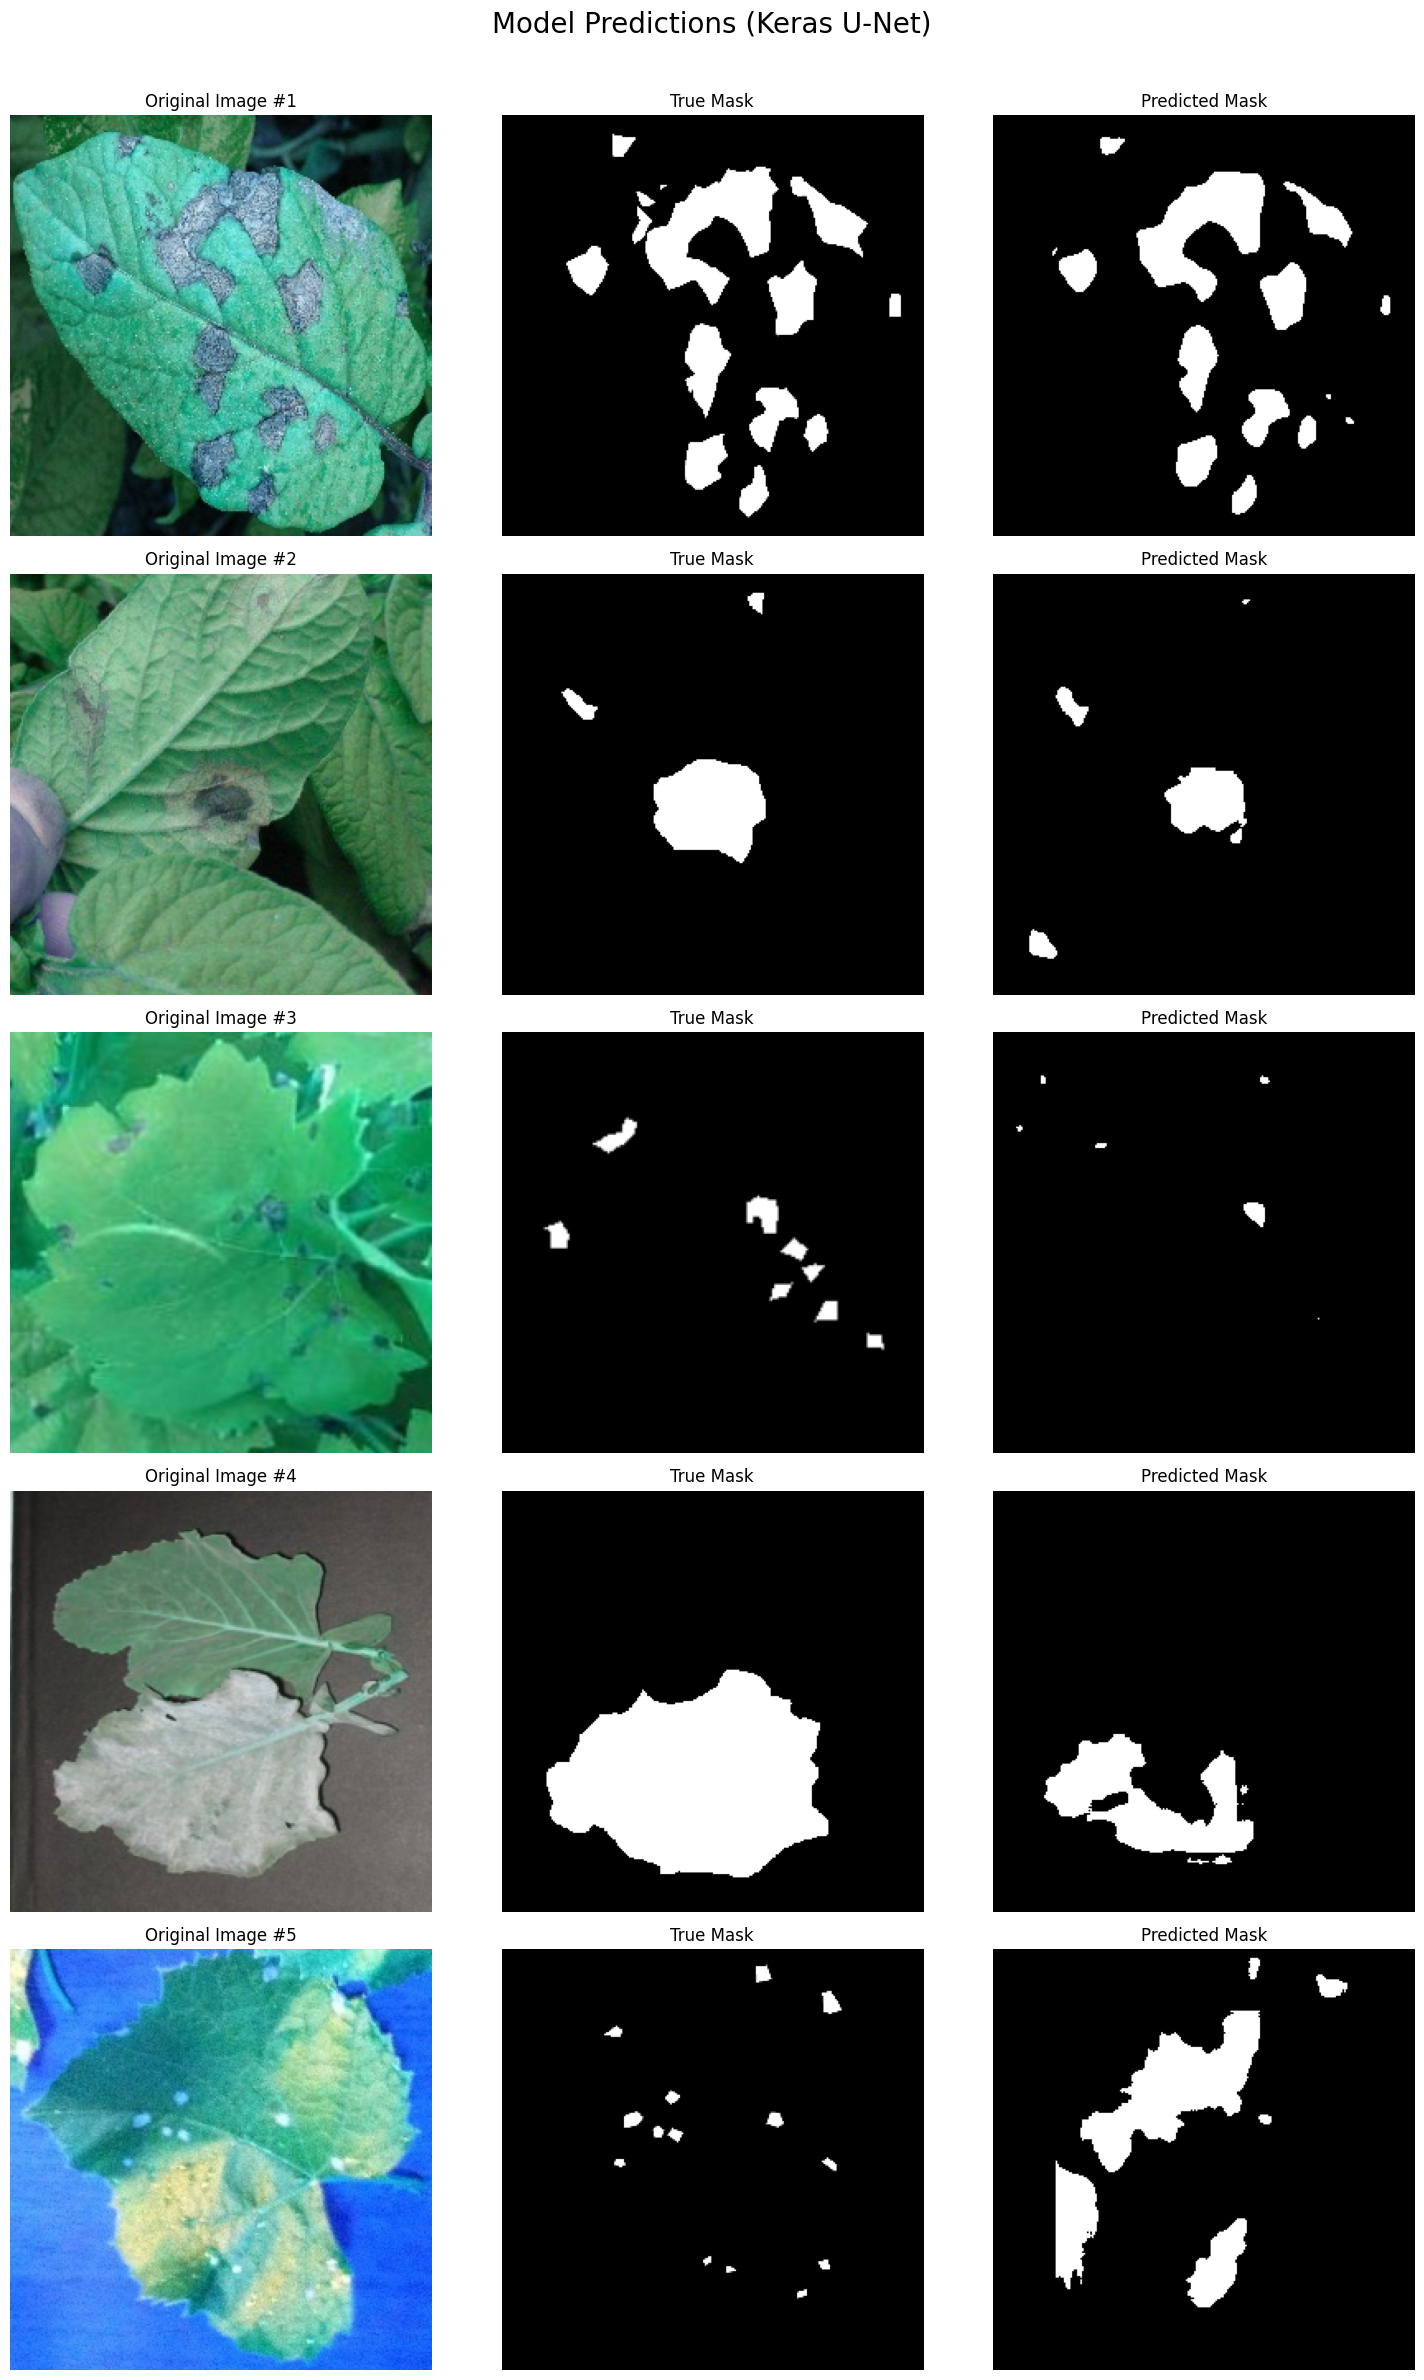

In [ ]:

# Get a batch of images from the validation set
num_to_show = 5
X_sample = X_val[:num_to_show]
y_sample = y_val[:num_to_show]

# Get predictions
preds = model.predict(X_sample)
# Apply a 0.5 threshold to get binary (0 or 1) masks
preds_binary = (preds > 0.5).astype(np.float32)

# Plot the results
fig, axs = plt.subplots(num_to_show, 3, figsize=(15, num_to_show * 5))
fig.suptitle("Model Predictions (Keras U-Net)", fontsize=20)
for i in range(num_to_show):
    # Display Original Image
    axs[i, 0].imshow(X_sample[i])
    axs[i, 0].set_title(f"Original Image #{i+1}")
    axs[i, 0].axis('off')

    # Display True Mask (Ground Truth)
    axs[i, 1].imshow(y_sample[i].squeeze(), cmap='gray')
    axs[i, 1].set_title("True Mask")
    axs[i, 1].axis('off')

    # Display Predicted Mask
    axs[i, 2].imshow(preds_binary[i].squeeze(), cmap='gray')
    axs[i, 2].set_title("Predicted Mask")
    axs[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("predictions_visualization.png")
print("Saved prediction visualization to 'predictions_visualization.png'")

In [ ]:

MODEL_SAVE_PATH = "leaf_segmentation_model.keras"

# Save in the modern .keras format
model.save(MODEL_SAVE_PATH)
